# Imports

if you face error while running pyfolio functions, the solution is here:<br>

https://stackoverflow.com/questions/63554616/attributeerror-numpy-int64-object-has-no-attribute-to-pydatetime

"fixed this by changing line 893 in file timeseries.py

valley = underwater.index[np.argmin(underwater)] # end of the period"

In [ ]:
%%capture
!gdown https://drive.google.com/uc?id=1LnLAUFIM3Ul1PfNYJXPn_z_4MIRUCaTS

In [ ]:
%%capture
!pip install pandas_market_calendars

In [ ]:
%%capture
!pip install pyfolio

In [ ]:
from google.colab import files
files.download('/usr/local/lib/python3.7/dist-packages/pyfolio/timeseries.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Parameters and Data

## Parameters

In [ ]:
parameters = {
    "symbols": ['AAA', 'AGR'],
    "begin": "2019-01-01",
    "end": "2020-01-01",
    "balance": 1000,  # init balance
    "order size": 10, # unit: $
    "stoploss": 0.95, # 95% of buy price
    "fee": 0.01,      # commission fee
    "hold days": 3 
}

## Generate OHLC candlestick

In [ ]:
def generate_ohlc(stock_name):
    df = pd.DataFrame()
    df['Open'] = open_data[stock_name]
    df['High'] = high_data[stock_name]
    df['Low'] = low_data[stock_name]
    df['Close'] = close_data[stock_name]
    df['Volume'] = volume_data[stock_name]
    return df

## Retrieve data

In [ ]:
close_data = gnt(stock_name, parameters["begin"], parameters["end"], 'Close')
open_data = gnt(stock_name, parameters["begin"], parameters["end"], 'Open')
high_data = gnt(stock_name, parameters["begin"], parameters["end"], 'High')
low_data = gnt(stock_name, parameters["begin"], parameters["end"], 'Low')
volume_data = gnt(stock_name, parameters["begin"], parameters["end"], 'Volume')
ohlc_list = [generate_ohlc(i) for i in parameters["symbols"]]

# Backtesting

## Deterministic signal generator

In [ ]:
# Generate deterministic buy/sell signal
def signal_gen_det(ohlc_data):
    df = pd.DataFrame(columns=ohlc_data[0].index)
    sig_list = [1, 0.4, 2, 2, -0.7, -0.5, 0]
    for n in range(len(ohlc_data)):
        df.loc[n] = pd.Series([sig_list[i%len(sig_list)] for i in range(df.shape[1])], index = df.columns)
    return df

## Random signal generator

In [ ]:
# Generate buy/sell signal in random perdiod according to OHLC candlesticks
def signal_gen_rand(ohlc_data):
    rand_start = random.randint(0, 15)
    rand_end = random.randint(1, 15)
    df = pd.DataFrame(columns=ohlc_data[0].iloc[rand_start:-rand_end].index)
    buy_signals = [0.6, 1]
    sell_signals = [-0.5, 0]
    for n in range(len(ohlc_data)):
        # buy if close >= open else sell
        df.loc[n] = pd.Series([(buy_signals[random.randint(0, len(buy_signals)-1)] if ohlc_data[n].Close.iloc[rand_start+i]>=ohlc_data[n].Open.iloc[rand_start+i] else sell_signals[random.randint(0, len(sell_signals)-1)]) for i in range(df.shape[1])], index = df.columns)
    return df

## Backtesting class

Signal values:<br>
    1: buy as much as order size<br>
    0: sell all bought symbol<br>
    (0, 1): buy a portion of order size according to signal value. e.g. if value is 0.5 buy half of order size<br>
    (-1, 0): sell a portion of bought symbol according to signal value
    
Hold days: ignore sell signal if did not reach hold days

In [ ]:
class backtest():
    def __init__(self, params, ohlc):
        self.ohlc = ohlc
        self.params = params
        
    def run(self, signal):
        if callable(signal):
            signal = signal(self.ohlc)
        
        self.trade_df = pd.DataFrame(columns = ['symbol', 'idx', 'type', 'date', 'size', 'total', 'price', 'sl', 'profit', 'balance'])
        stoploss = [0] * signal.shape[0]
        total_size = [0] * signal.shape[0]
        hold_dur = [signal.columns[0]] * signal.shape[0]
        price_avg = [0] * signal.shape[0] # use to calculate profit
        balance = self.params['balance']
        for i in range(signal.shape[1]):
            for s in range(signal.shape[0]):
                symbol = self.params["symbols"][s]
                ohlc_val = self.ohlc[s].loc[signal.columns[i]]
                signal_val = signal.iloc[s, i]
                price = ohlc_val.Open
                if signal_val == 1:
                    trade_type = 'buy'
                    size = self.params["order size"]
                    size = min(size, balance / (1+self.params['fee']))
                    if size:
                        hold_dur[s] = signal.columns[i]
                        balance -= (1 + self.params['fee']) * size
                        size /= price
                        stoploss[s] = self.params['stoploss'] * price
                        price_avg[s] = (price_avg[s]*total_size[s] + (1 + self.params['fee']) * price*size) / (total_size[s]+size)
                        total_size[s] += size
                        profit = 0
                        
                # buy a portion of order size according to signal value
                elif 0 < signal_val < 1:
                    trade_type = 'buy_por'
                    size = self.params["order size"] * signal_val
                    size = min(size, balance / (1+self.params['fee']))
                    if size:
                        hold_dur[s] = signal.columns[i]
                        balance -= (1 + self.params['fee']) * size
                        size /= price
                        stoploss[s] = self.params['stoploss'] * price
                        price_avg[s] = (price_avg[s]*total_size[s] + (1 + self.params['fee']) * price*size) / (total_size[s]+size)
                        total_size[s] += size
                        profit = 0
                # sell all
                elif signal_val == 0:
                    trade_type = 'sell'
                    size = total_size[s] if (signal.columns[i]-hold_dur[s]).days >= self.params["hold days"] else 0
                    total_size[s] -= size
                    balance += (1 - self.params['fee']) * size * price
                    profit = size * (price_avg[s] - price)
                # sell a portion of bought symbol according to signal value
                elif -1 <= signal_val < 0:
                    trade_type = 'sell_por'
                    size = total_size[s] * abs(signal_val) if (signal.columns[i]-hold_dur[s]).days >= self.params["hold days"] else 0
                    total_size[s] -= size
                    balance += (1 - self.params['fee']) * size * price
                    profit = size * ((1 - self.params['fee']) * price - price_avg[s])
                else:
                    size = 0
                
                if size:
                    self.trade_df.loc[self.trade_df.shape[0]] = pd.Series([symbol, i, trade_type,
                                                                           signal.columns[i], size, total_size[s], price,
                                                                           stoploss[s] if total_size[s] else 0, profit, balance], 
                                                                           index = self.trade_df.columns)
                # check stop loss
                if ohlc_val.Low <= stoploss[s] and total_size[s]:
                    trade_type = 'sell_sl'
                    price = stoploss[s]
                    size = total_size[s]
                    total_size[s] = 0
                    balance += (1 - self.params['fee']) * size * price
                    profit = size * ((1 - self.params['fee']) * price - price_avg[s])
                    self.trade_df.loc[self.trade_df.shape[0]] = pd.Series([symbol, i, trade_type,
                                                                           signal.columns[i], size, total_size[s], price,
                                                                           stoploss[s] if total_size[s] else 0, profit, balance], 
                                                                           index = self.trade_df.columns)
                # create manual sell order to calculate the profit
                if i == (signal.shape[1]-1):
                    trade_type = 'sell_end'
                    price = ohlc_val.Close
                    size = total_size[s]
                    total_size[s] = 0
                    balance += (1 - self.params['fee']) * size * price
                    profit = size * ((1 - self.params['fee']) * price - price_avg[s])
                    self.trade_df.loc[self.trade_df.shape[0]] = pd.Series([symbol, i, trade_type,
                                                                           signal.columns[i], size, total_size[s], price,
                                                                           stoploss[s] if total_size[s] else 0, profit, balance], 
                                                                           index = self.trade_df.columns)
        nyse = mcal.get_calendar('NYSE')
        tradingCalendar = nyse.schedule(start_date=self.trade_df['date'].iloc[0], end_date=self.trade_df['date'].iloc[-1])
        self.st_df = pd.DataFrame(tradingCalendar.index.astype(str).tolist() + self.trade_df['date'].astype(str).tolist(), columns = ['date']).drop_duplicates('date').sort_values('date').reset_index(drop = True)
        self.st_df['balance'] = self.params['balance']
        self.st_df['wallet'] = self.params['balance']
        self.st_df['profit'] = 0
        self.st_df['dailyReturn'] = 0
        self.st_df['drawdown'] = 0
        self.st_df['drawdownValue'] = 0
        for i in range(self.st_df.shape[0]):
            match = self.trade_df[self.trade_df.date == self.st_df.date.iloc[i]]
            self.st_df.balance.iloc[i] = self.st_df.balance.iloc[i-1] if match.empty else match.balance.iloc[-1]
            self.st_df.profit.iloc[i] = match.profit.sum()
            self.st_df.wallet.iloc[i] = (self.st_df.wallet.iloc[i-1] + self.st_df.profit.iloc[i]) if i else self.st_df.wallet.iloc[i]
            self.st_df.dailyReturn.iloc[i] = self.st_df.profit.iloc[i]/self.st_df.wallet.iloc[i-1] if i else 0
            self.st_df.drawdown.iloc[i] = min((self.st_df.wallet.iloc[i]-self.st_df.wallet.iloc[:i].max())/self.st_df.wallet.iloc[:i].max(), 0)
            self.st_df.drawdownValue.iloc[i] = min((self.st_df.wallet.iloc[i]-self.st_df.wallet.iloc[:i].max()), 0)
        
        display(self.trade_df)
    
    def general_stats(self):
        sell_const = self.trade_df.type.str.contains("sell")
        buy_const = self.trade_df.type.str.contains("buy")
        win_const = (sell_const) & (self.trade_df.profit >= 0)
        loss_const = (sell_const) & (self.trade_df.profit < 0)
        winRate = bt.trade_df[win_const].shape[0] / bt.trade_df[sell_const].shape[0]

        self.cumulative_return = self.st_df['wallet'].iloc[-1]/self.st_df['wallet'].iloc[0] -1
        self.annual_return = self.cumulative_return/(self.trade_df.date.iloc[-1] - self.trade_df.date.iloc[0]).days*365
        print(f'Win trades: {self.trade_df[win_const].shape[0]}')
        print(f'Loss trades: {self.trade_df[loss_const].shape[0]}')
        print(f'Buy trades: {self.trade_df[buy_const].shape[0]}')
        print(f'Sell trades: {self.trade_df[sell_const].shape[0]}')
        print(f'Total net profit: {self.trade_df.profit.sum():.5}')
        print(f'Gross profit: {self.trade_df[self.trade_df.profit > 0].profit.sum():.5}')
        print(f'Gross loss: {self.trade_df[self.trade_df.profit < 0].profit.sum():.5}')
        print(f'Profit factor: {abs(self.trade_df[self.trade_df.profit > 0].profit.sum()/self.trade_df[self.trade_df.profit < 0].profit.sum()):.3}')
        print(f'Recovery factor: {self.trade_df.profit.sum()/abs(self.st_df.drawdownValue.min()):.3}')
        print(f'Expected payoff: {self.trade_df.profit.sum()/bt.trade_df.shape[0]:.5}')
        print(f'Payoff ratio: {abs(self.trade_df[self.trade_df.profit > 0].profit.mean()/self.trade_df[self.trade_df.profit < 0].profit.mean()):.5}')
        print(f'Largest profit trade: {self.trade_df.profit.max():.3}')
        print(f'Largest loss trade: {self.trade_df.profit.min():.3}')
        print(f'Average profit trade: {self.trade_df[self.trade_df.profit>0].profit.mean():.3}')
        print(f'Average loss trade: {self.trade_df[self.trade_df.profit<0].profit.mean():.3}')
        print(f'Winning rate: {winRate*100:.3}%')
        print(f'Cumulative Return: {self.cumulative_return * 100:.3}%')
        print(f'Annual Return: {self.annual_return * 100:.3}%')
        crs = self.st_df['wallet'] / self.st_df['wallet'].iloc[0] * 100
        ax = crs.plot(linewidth=3, title = 'Cumulative Return', figsize = (30,7))
        ax.axhline(y=100, linewidth=2, color='orange', linestyle='--')
        
    def cal_drawdown(self):
        print(f'Maximum Drawdown: {self.st_df.drawdownValue.min():.5}')
        print(f'Maximum Drawdown Relative: {self.st_df.drawdown.min()*100:.3}%')
        # ax = (self.st_df.drawdownValue).plot(linewidth=3, title = 'Drawdown', figsize = (30,7))
        # ax.axhline(y=0, linewidth=2, color='orange', linestyle='--')
        ax = (self.st_df.drawdown*100).plot(linewidth=3, title = 'Drawdown Relative', figsize = (30,7))
        ax.axhline(y=0, linewidth=2, color='orange', linestyle='--')
    
    def cal_sharp_ratio(self):
        Sharpe_Ratio = self.st_df.dailyReturn.mean() / self.st_df.dailyReturn.std()
        asr = Sharpe_Ratio*252**.5    # 252 is annual trading days
        print(f'Sharpe Ratio: {Sharpe_Ratio:.3}')
        print(f'Annualize Sharpe Ratio: {asr:.3}')
        
    def cal_VaR(self):
        st_mean = self.st_df.profit.mean()
        st_std = self.st_df.profit.std()
        VaR_90 = norm.ppf(1-0.9, st_mean, st_std)
        VaR_95 = norm.ppf(1-0.95, st_mean, st_std)
        VaR_99 = norm.ppf(1-0.99, st_mean, st_std)
        print(f'Daily VaR:\r\n\t90%: {VaR_90:.4}\r\n\t95%: {VaR_95:.4}\r\n\t99%: {VaR_99:.4}')
        self.st_df.profit.hist(bins=40, histtype='stepfilled', alpha=1.0, figsize=(20,7))
        
    def pyfolio(self):
        returns = pd.Series(data = self.st_df['dailyReturn'].tolist(), index = self.st_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')).tolist())
        pf_res = pf.create_returns_tear_sheet(returns, return_fig=True)
        pf_res.savefig('returns_tear_sheet.pdf')

## Create backtesting object

In [ ]:
bt = backtest(parameters, ohlc_list)

## Deterministic backtest

In [ ]:
# signals = signal_gen_det(ohlc_list)
# bt.run(signals)

## Function backtest

In [ ]:
bt.run(signal_gen_rand)

,symbol,idx,type,date,size,total,price,sl,profit,balance
0,AAA,0,buy_por,2019-02-05,0.412371,0.412371,14.55,13.8225,0,993.940000
1,AAA,1,buy_por,2019-02-06,0.412371,0.824742,14.55,13.8225,0,987.880000
2,AAA,2,buy_por,2019-02-07,0.412371,1.237113,14.55,13.8225,0,981.820000
3,AAA,3,buy_por,2019-02-08,0.412371,1.649485,14.55,13.8225,0,975.760000
4,AAA,4,buy_por,2019-02-11,0.404040,2.053525,14.85,14.1075,0,969.700000
...,...,...,...,...,...,...,...,...,...,...
302,AGR,225,buy,2019-12-17,2.958580,2.958580,3.38,3.2110,0,952.481256
303,AAA,227,sell,2019-12-19,2.388219,0.000000,13.85,0.0000,0.758166,985.227321
304,AAA,227,sell_end,2019-12-19,0.000000,0.000000,13.55,0.0000,-0.0,985.227321
305,AGR,227,buy_por,2019-12-19,1.764706,4.723286,3.40,3.2300,0,979.167321


## General Stats

Win trades: 31
Loss trades: 41
Buy trades: 235
Sell trades: 72
Total net profit: 4.9603
Gross profit: 26.565
Gross loss: -21.605
Profit factor: 1.23
Recovery factor: 0.449
Expected payoff: 0.016157
Payoff ratio: 1.6804
Largest profit trade: 7.79
Largest loss trade: -4.97
Average profit trade: 0.886
Average loss trade: -0.527
Winning rate: 43.1%
Cumulative Return: 0.496%
Annual Return: 0.571%


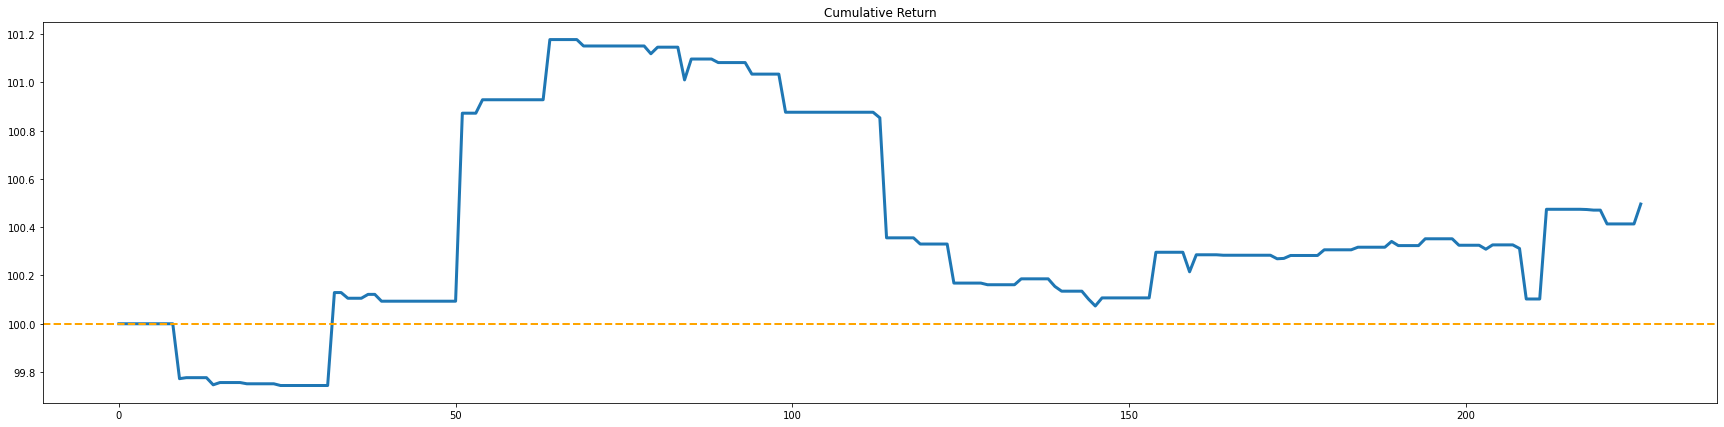

In [ ]:
bt.general_stats()

## Drawdown

Maximum Drawdown: -11.039
Maximum Drawdown Relative: -1.09%


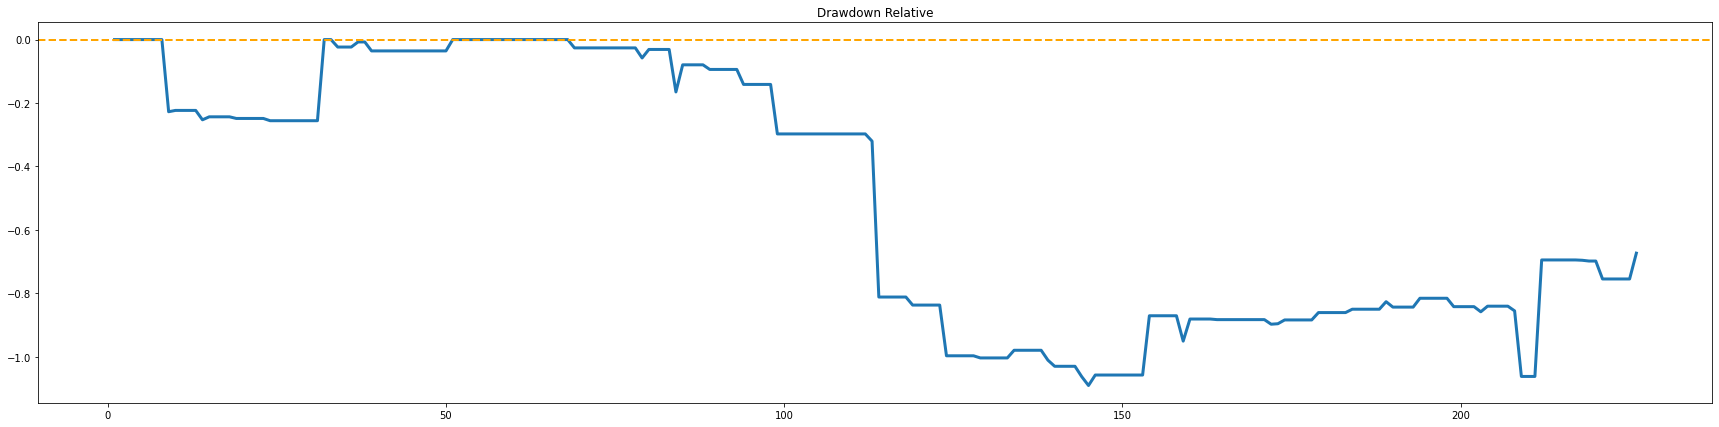

In [ ]:
bt.cal_drawdown()

## Sharp ratio

In [ ]:
bt.cal_sharp_ratio()

Sharpe Ratio: 0.0277
Annualize Sharpe Ratio: 0.439


## Value at Risk

Daily VaR:
	90%: -1.006
	95%: -1.297
	99%: -1.844


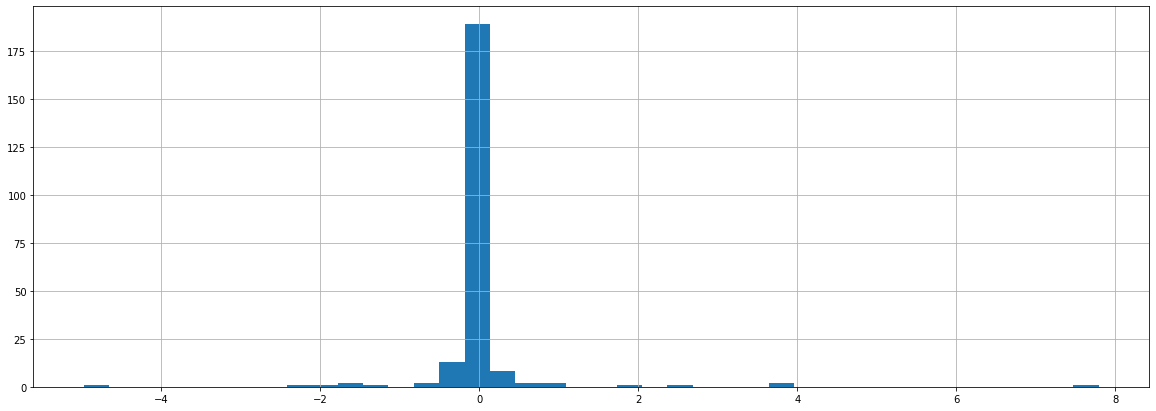

In [ ]:
bt.cal_VaR()

## Pyfolio stats

Start date,2019-02-05
End date,2019-12-19
Total months,10
,Backtest
Annual return,0.6%
Cumulative returns,0.5%
Annual volatility,1.3%
Sharpe ratio,0.44
Calmar ratio,0.50
Stability,0.00
Max drawdown,-1.1%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.09,2019-05-10,2019-08-27,NaT,NaN
1,0.26,2019-02-15,2019-03-11,2019-03-21,25
2,0.04,2019-03-22,2019-04-01,2019-04-17,19
3,0.00,2019-02-05,2019-02-05,2019-02-05,1
4,0.00,2019-02-05,2019-02-05,2019-02-05,1


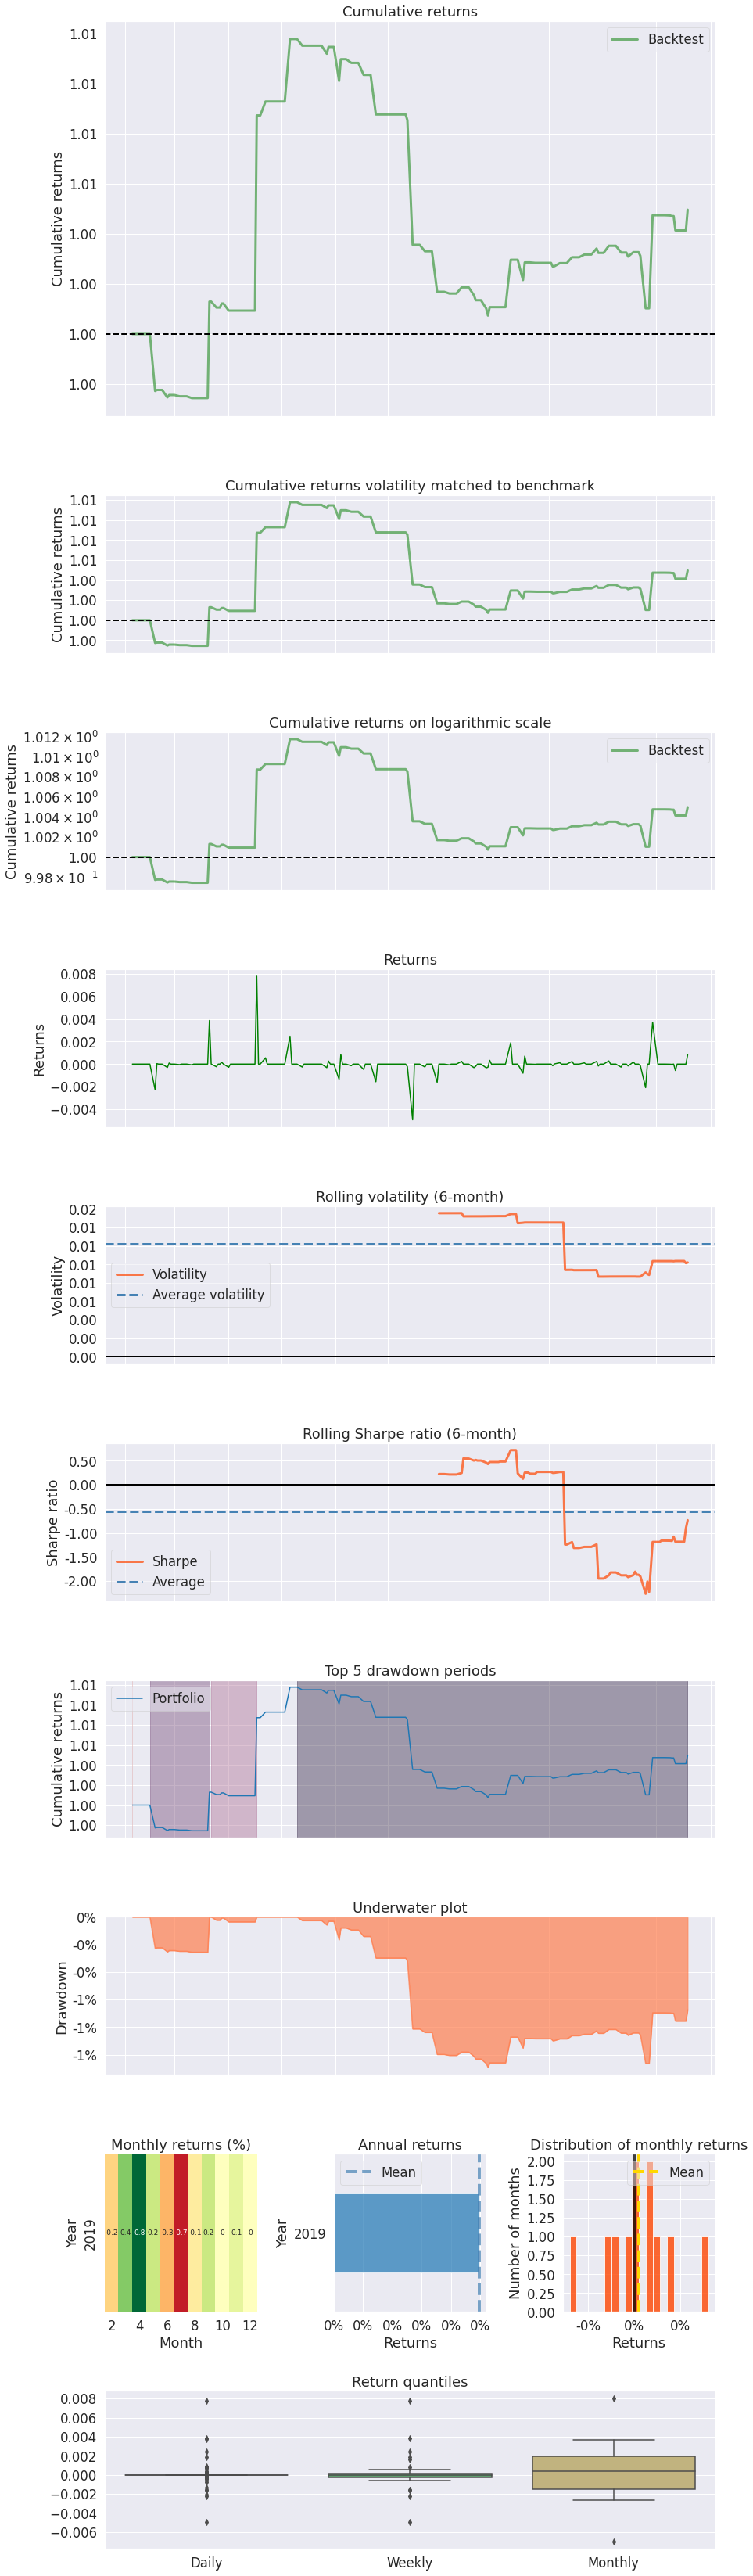

In [ ]:
bt.pyfolio()